### Train LNN with SO2 projection with gradeint
- Checked Ground truth
- Checked ODE in SO2 form and original form
- Everything Match

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from torchdyn.models import NeuralODE

from module import StructuredSO2LNN
from nn import MLP, PSD

from gym_env import PendulumCustomEnv
from data import Gym_DataModule

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [3]:
env = PendulumCustomEnv(full_phase=True)
controls = np.array([[0.]])  # (num of control, dim)

# env, time step, traj, control
dataModule = Gym_DataModule(env, 100, 100, controls, time_horizon=5, batch_size=2048)
dataModule.setup()

In [4]:
M = PSD([2, 64, 64, 1], activation='softplus')  # Mass matrix, M(x1, x2)
V = MLP([2, 64, 64, 1], activation='softplus')  # Potential V(x1, x2)

LagFunc = StructuredSO2LNN(massMatrixNet=M,
                           potentialNet=V,
                           dim=1)

LagODE = NeuralODE(LagFunc, sensitivity='adjoint', solver='rk4').to(device)

In [5]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss
        self.n = self.model.defunc.m.n

    def forward(self, x_dx0, t_span):
        return self.model.trajectory(x_dx0, t_span)

    def training_step(self, batch, batch_idx):
        x, _, t, infos = batch
        t_span = t[0, :, 0]

        # # x.shape: (bs, time, [cos q, sin q, dq])

        # For checking the loss
        dx1x2dq = self.model.defunc(0, x[:, 0, :])
        
        dx1 = torch.multiply(torch.cos(infos[:, 0, 0]), infos[:, 0, 1])
        dx2 = torch.multiply(torch.sin(infos[:, 0, 0]), infos[:, 0, 1])
        target = torch.stack([dx1, dx2, infos[:, 0, 2]], dim=1)
        
        loss = self.loss_func(dx1x2dq, target)

        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _, t, infos = batch
        t_span = t[0, :, 0]

        # # x.shape: (bs, time, [cos q, sin q, dq])

        # For checking the loss
        dx1x2dq = self.model.defunc(0, x[:, 0, :])
        
        dx1 = torch.multiply(torch.cos(infos[:, 0, 0]), infos[:, 0, 1])
        dx2 = torch.multiply(torch.sin(infos[:, 0, 0]), infos[:, 0, 1])
        target = torch.stack([dx1, dx2, infos[:, 0, 2]], dim=1)
        
        loss = self.loss_func(dx1x2dq, target)

        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-4)

In [6]:
# Use pl for training
learn = Learner(LagODE)
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=1e-5, patience=20)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)  # tqdm bug mess with PyCharm
trainer.fit(learn, dataModule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 8.8 K 
------------------------------------
8.8 K     Trainable params
0         Non-trainable params
8.8 K     Total params
0.035     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impro

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 15.108
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.097 >= min_delta = 1e-05. New best score: 15.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.095 >= min_delta = 1e-05. New best score: 14.916


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.094 >= min_delta = 1e-05. New best score: 14.822


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.093 >= min_delta = 1e-05. New best score: 14.730


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.092 >= min_delta = 1e-05. New best score: 14.638


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.091 >= min_delta = 1e-05. New best score: 14.546


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.091 >= min_delta = 1e-05. New best score: 14.455


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.092 >= min_delta = 1e-05. New best score: 14.363


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.093 >= min_delta = 1e-05. New best score: 14.270


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.094 >= min_delta = 1e-05. New best score: 14.176


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.096 >= min_delta = 1e-05. New best score: 14.080


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.098 >= min_delta = 1e-05. New best score: 13.982


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.101 >= min_delta = 1e-05. New best score: 13.881


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.104 >= min_delta = 1e-05. New best score: 13.777


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.108 >= min_delta = 1e-05. New best score: 13.670


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.112 >= min_delta = 1e-05. New best score: 13.558


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.117 >= min_delta = 1e-05. New best score: 13.441


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.123 >= min_delta = 1e-05. New best score: 13.318


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.129 >= min_delta = 1e-05. New best score: 13.189


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.138 >= min_delta = 1e-05. New best score: 13.051


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.149 >= min_delta = 1e-05. New best score: 12.902


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.161 >= min_delta = 1e-05. New best score: 12.741


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.176 >= min_delta = 1e-05. New best score: 12.565


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.196 >= min_delta = 1e-05. New best score: 12.369


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.220 >= min_delta = 1e-05. New best score: 12.150


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.251 >= min_delta = 1e-05. New best score: 11.899


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.292 >= min_delta = 1e-05. New best score: 11.607


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.345 >= min_delta = 1e-05. New best score: 11.262


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.417 >= min_delta = 1e-05. New best score: 10.845


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.513 >= min_delta = 1e-05. New best score: 10.332


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.641 >= min_delta = 1e-05. New best score: 9.691


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.807 >= min_delta = 1e-05. New best score: 8.885


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.016 >= min_delta = 1e-05. New best score: 7.869


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.252 >= min_delta = 1e-05. New best score: 6.617


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.480 >= min_delta = 1e-05. New best score: 5.137


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.627 >= min_delta = 1e-05. New best score: 3.510


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.571 >= min_delta = 1e-05. New best score: 1.939


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.204 >= min_delta = 1e-05. New best score: 0.735


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.545 >= min_delta = 1e-05. New best score: 0.190


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 1e-05. New best score: 0.180


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.069 >= min_delta = 1e-05. New best score: 0.111


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 1e-05. New best score: 0.098


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 1e-05. New best score: 0.090


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.088


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.087


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.084


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 0.081


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.079


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.078


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.076


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.074


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.072


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.070


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.068


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.066


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.064


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.063


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.061


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.060


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.058


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.057


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.055


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.054


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.052


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.051


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.050


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.049


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.047


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.046


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.045


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.044


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.043


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.042


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.041


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.040


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.039


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.038


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.037


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.036


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.036


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.035


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.034


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.033


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.033


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.032


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.031


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.031


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.030


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.029


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.029


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.028


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.028


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.027


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.027


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.026


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.026


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.025


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.025


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.024


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.024


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.024


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.023


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.023


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.023


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.022


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.022


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.022


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.021


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.021


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.021


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.020


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.019


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.017


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.016


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.014


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.008


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.006
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


In [7]:
env = PendulumCustomEnv()
env.seed(1)

obs = []
infos = []

obs0 = env.reset(np.array([3, 0.]))
obs.append(obs0)
for i in range(1000-1):
    cur_obs, reward, done, info = env.step(0)
    obs.append(cur_obs)
    infos.append(np.array([info['theta'], info['theta_dot'], info['theta_dotdot']]))

obs = torch.tensor(obs)
infos = torch.tensor(infos)
print(obs0)

[0.14112001 0.9899925  0.        ]


In [8]:
full = 1000
time = 100
t_span = torch.linspace(0, 0.05*full, full)

In [9]:
# Check gardient output
# 100 percent match
est_grad = learn.model.defunc(0, obs.float())

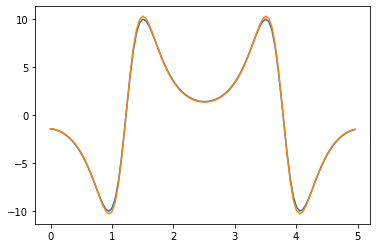

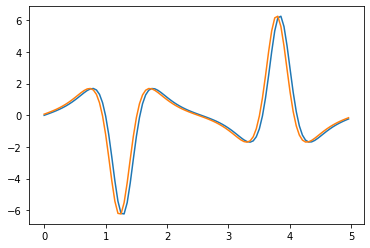

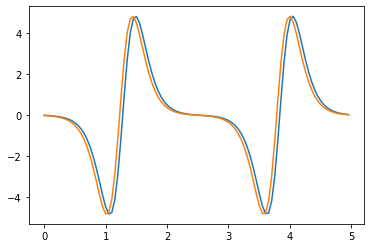

In [10]:
# Check ddq
time = 100
plt.plot(t_span.detach().numpy()[:time], infos[:time, 2])  # Ground truth
plt.plot(t_span.detach().numpy()[:time], est_grad[1:time+1, 2].detach().numpy())  # LNN
plt.show()

# check dx1
time = 100
plt.plot(t_span.detach().numpy()[:time], -obs[:time, 1] * obs[:time, 2])  # ground truth
plt.plot(t_span.detach().numpy()[:time], est_grad[1:time+1, 0].detach().numpy())  # LNN
plt.show()

# Check dx2
time = 100
plt.plot(t_span.detach().numpy()[:time], obs[:time, 0] * obs[:time, 2])  # Observation + ground truth
plt.plot(t_span.detach().numpy()[:time], est_grad[1:time+1, 1].detach().numpy())  # LNN
plt.show()

In [11]:
x1x2_dq_0 = obs[[0], :]
est = learn.model.trajectory(x1x2_dq_0.float(), t_span)  # This is not working?

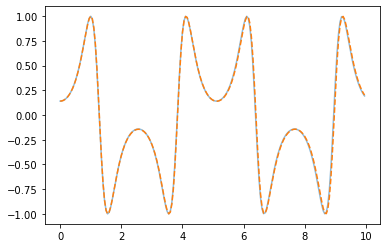

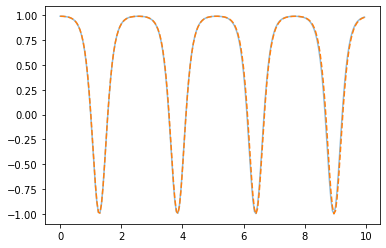

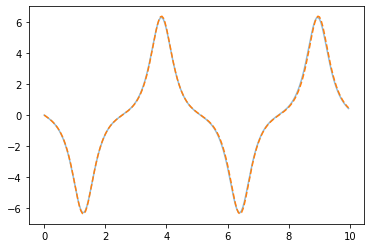

In [12]:
# Plot cos q = x
time = 200
plt.plot(t_span.detach().numpy()[:time], obs[:time, 0].detach().numpy(), alpha=0.5)
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 0].detach().numpy(), '--', alpha=1)
plt.show()

# Plot sin q = y
plt.plot(t_span.detach().numpy()[:time], obs[:time, 1].detach().numpy(), alpha=0.5)
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 1].detach().numpy(), '--', alpha=1)
plt.show()

# Plot dq
plt.plot(t_span.detach().numpy()[:time], obs[:time, 2].detach().numpy(), alpha=0.5)
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 2].detach().numpy(), '--', alpha=1)
plt.show()

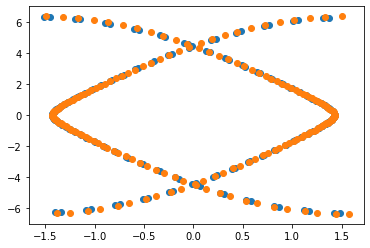

In [13]:
# Plot Phase Space traj
th = torch.atan(obs[:time, 1] / obs[:time, 0])
thdot = obs[:time, 2]

est_th = torch.atan(est[:time, 0, 1] / est[:time, 0, 0])
est_thdot = est[:time, 0, 2]

plt.scatter(th, thdot)
plt.scatter(est_th.detach().numpy(), est_thdot.detach().numpy())

In [14]:
# Check with solve_ivp
from scipy.integrate import solve_ivp

In [15]:
def dummy_bs(t, y):
    # [cos q, sin q, dq]
    if type(y) == torch.Tensor:
        y = y.detach().numpy()
    dx1 = np.multiply(-y[:, 1], y[:, 2])
    dx2 = np.multiply(y[:, 0], y[:, 2])
    ddq = -10 * y[:, 0]
    return np.stack([dx1, dx2, ddq], axis=1)

def dummy2_bs(t, y):
    if type(y) == torch.Tensor:
        y = y.detach().numpy()
    th = y[:, 0]
    dth = y[:, 1]
    grad = np.stack([dth, -10 * np.sin(th)], axis=1)
    return grad

def dummy(t, y):
    dx1 = np.multiply(-y[1], y[2])
    dx2 = np.multiply(y[0], y[2])
    ddq = -10 * y[0]
    return [dx1, dx2, ddq]

def dummy2(t, y):
    th = y[0]
    dth = y[1]
    grad = [dth, -10 * np.sin(th)]
    return grad

In [16]:
# try solve_ivp
sol1 = solve_ivp(dummy, [0., 10.], obs[1, :].detach().numpy(), method='Radau')
sol2 = solve_ivp(dummy2, [0., 10.], infos[0, 0:2].detach().numpy(), method='Radau')

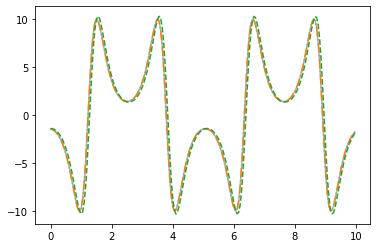

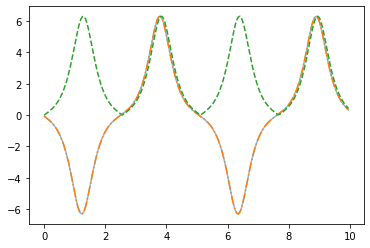

In [17]:
# Check [q, dq] grad representation
time = 200
dummy_test2 = dummy2_bs(0, infos[:, 0:2])

# Check ddq
plt.plot(t_span.detach().numpy()[:time], dummy_test2[:time, 1], alpha=0.5)  # From ODE in th
plt.plot(t_span.detach().numpy()[:time], infos[:time, 2].detach().numpy(), '-.')  # From Ground truth
plt.plot(t_span.detach().numpy()[:time], est_grad[:time, 2].detach().numpy(), '--')  # From LNN
plt.show()

# Check dq
plt.plot(t_span.detach().numpy()[:time], dummy_test2[:time, 0], alpha=0.5)  # From ODE in th
plt.plot(t_span.detach().numpy()[:time], infos[:time, 1].detach().numpy(), '-.')  # From Ground truth (Have error from integrator)
plt.plot(t_span.detach().numpy()[:time], np.sqrt(est_grad[:time, 0].detach().numpy() ** 2 + est_grad[:time, 1].detach().numpy() ** 2), '--')  # From LNN


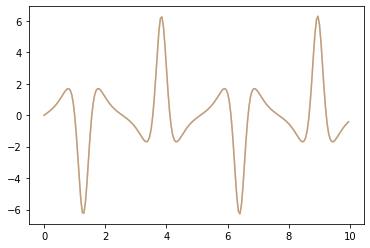

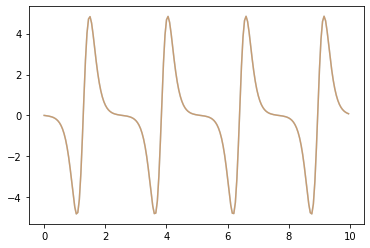

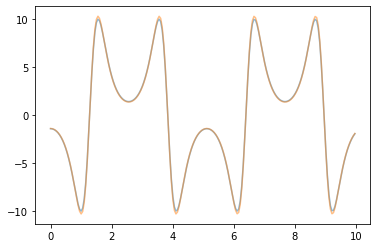

In [18]:
# Check [q, dq] grad representation
time = 200
dummy_test = dummy_bs(0, obs)

# Check dx1
plt.plot(t_span.detach().numpy()[:time], dummy_test[:time, 0], alpha=0.5)  # From ODE in th
plt.plot(t_span.detach().numpy()[:time], est_grad[:time, 0].detach().numpy(), alpha=0.5)  # From LNN
plt.show()

# Check dx2
plt.plot(t_span.detach().numpy()[:time], dummy_test[:time, 1], alpha=0.5)  # From ODE in th
plt.plot(t_span.detach().numpy()[:time], est_grad[:time, 1].detach().numpy(), alpha=0.5)  # From LNN
plt.show()

# Check ddq
plt.plot(t_span.detach().numpy()[:time], dummy_test[:time, 2], alpha=0.5)  # From ODE in th
plt.plot(t_span.detach().numpy()[:time], est_grad[:time, 2].detach().numpy(), alpha=0.5)  # From LNN
plt.show()

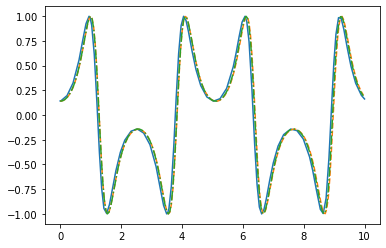

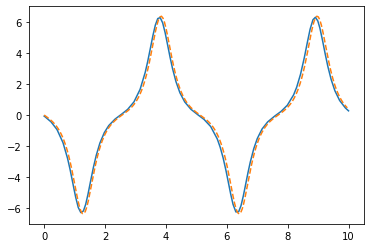

In [19]:
# Check [cos q, sin q, dq] representation
time = 200

# Check cos q. Doesnt match
plt.plot(sol1.t, sol1.y[0, :])  # IVP
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 0].detach().numpy(), '--', alpha=1)  # LNN
plt.plot(t_span.detach().numpy()[:time], obs[:time, 0].detach().numpy(), '-.', alpha=1)  # from Env
plt.show()

# Check dq. Doesnt match
plt.plot(sol1.t, sol1.y[2, :])
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 2].detach().numpy(), '--', alpha=1)  # LNN
plt.show()

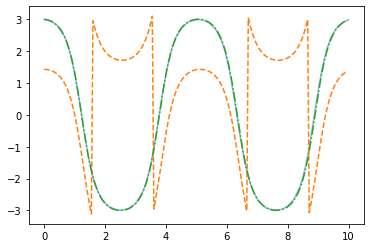

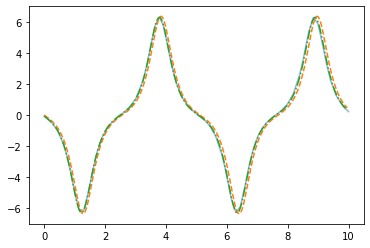

In [32]:
# Check [q, dq] representation
# Check q
est_th = np.arctan2(est[:time, 0, 1].detach().numpy(), est[:time, 0, 0].detach().numpy())
plt.plot(sol2.t, sol2.y[0, :], alpha=0.5)  # IVP solution
plt.plot(t_span.detach().numpy()[:time], est_th, '--', alpha=1)  # LNN, compress with [-pi/2, pi/2]
plt.plot(t_span.detach().numpy()[:time], infos[:time, 0].detach().numpy(), '-.', alpha=1)  # Truth
plt.show()


# Check dq
plt.plot(sol2.t, sol2.y[1, :], alpha=0.5)  # IVP solution
plt.plot(t_span.detach().numpy()[:time], est[:time, 0, 2].detach().numpy(), '--', alpha=1)  # LNN
plt.plot(t_span.detach().numpy()[:time], infos[:time, 1].detach().numpy(), '-.', alpha=1)  # Truth
plt.show()